# Comparison of sampling algorithms

In [1]:
from collections import OrderedDict

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np
from scipy import stats
from scipy.stats import invgamma, norm

In [4]:
import corner

In [5]:
import rxmc

Using database version X4-2024-12-31 located in: /home/beyerk/db/exfor/unpack_exfor-2024/X4-2024-12-31


In [6]:
true_params = OrderedDict(
    [
        ("m", 2),
        ("b", 4),
    ]
)

In [7]:
rng = np.random.default_rng(42)

In [8]:
noise = 0.05
N = 15
x_data = np.random.rand(N)
y_true = true_params["m"] * x_data + true_params["b"]
y_err = np.array([rng.normal(0, noise * y) for y in y_true])
y_data = y_true + y_err

# Define priors: (mean, variance) for normal, (alpha, beta) for inverse gamma
reported_stat_err = noise * np.mean(y_data)
m_prior = (2, 10)
b_prior = (1, 10)
sigma2_prior = (3, reported_stat_err / (3 - 1))

In [9]:
class LinearModel(rxmc.physical_model.PhysicalModel):
    def __init__(self):
        params = [
            rxmc.params.Parameter("m", float, "no-units"),
            rxmc.params.Parameter("b", float, "y-units"),
        ]
        super().__init__(params)

    def evaluate(self, observation, m, b):
        return self.y(observation.x, m, b)

    def y(self, x, m, b):
        # useful to have a function hat takes in an array-like x
        # rather than an Observation, e.g. for plotting
        return m * x + b

In [10]:
prior_mean = OrderedDict(
    [
        ("m", 1),
        ("b", 5),
    ]
)
prior_std_dev = OrderedDict(
    [
        ("m", 0.5),
        ("b", 0.5),
    ]
)

In [11]:
covariance = np.diag(list(prior_std_dev.values())) ** 2
mean = np.array(list(prior_mean.values()))
prior_distribution = stats.multivariate_normal(mean, covariance)

In [12]:
my_model = LinearModel()

In [13]:
observation = rxmc.observation.Observation(
    x=x_data,
    y=y_data,
    y_stat_err=y_true * noise,
)

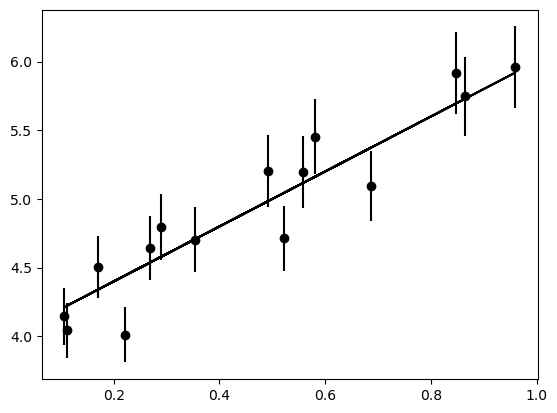

In [14]:
plt.errorbar(
    x_data,
    y_data,
    noise * y_data,
    color="k",
    marker="o",
    linestyle="none",
    label="experiment with bias",
)
plt.plot(x_data, y_true, "k", label="truth")

In [15]:
likelihood = rxmc.likelihood_model.LikelihoodModel()
likelihood_unknown_stat = rxmc.likelihood_model.UnknownNoiseFractionErrorModel()

In [16]:
evidence = rxmc.evidence.Evidence(
    [
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood,
        )
    ]
)
evidence_us = rxmc.evidence.Evidence(
    parametric_constraints=[
        rxmc.constraint.Constraint(
            [observation],
            my_model,
            likelihood_unknown_stat,
        )
    ]
)

### Sampling configurations for the model parameters

In [17]:
def proposal_distribution(x, rng):
    return stats.multivariate_normal.rvs(
        mean=x, cov=prior_distribution.cov / 100, random_state=rng
    )


metropolis_model = rxmc.param_sampling.MetropolisHastingsSampler(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    proposal=proposal_distribution,
    prior=prior_distribution,
)

In [18]:
adaptive_model = rxmc.param_sampling.AdaptiveMetropolisSampler(
    params=my_model.params,
    starting_location=prior_distribution.mean,
    prior=prior_distribution,
)

### Sampling configurations for the likelihood parameters

In [19]:
noise_prior = stats.norm(loc=np.log(0.01), scale=1)

In [20]:
def proposal_distribution_log_noise(x, rng):
    return np.atleast_1d(stats.norm.rvs(loc=x, scale=0.1, random_state=rng))


metropolis_likelihood = rxmc.param_sampling.MetropolisHastingsSampler(
    params=likelihood_unknown_stat.params,
    starting_location=np.array(noise_prior.mean()),
    proposal=proposal_distribution_log_noise,
    prior=noise_prior,
)

In [21]:
adaptive_likelihood = rxmc.param_sampling.AdaptiveMetropolisSampler(
    params=likelihood_unknown_stat.params,
    starting_location=np.array(noise_prior.mean()),
    prior=noise_prior,
)

## Walkers

In [22]:
walker_metropolis = rxmc.walker.Walker(
    metropolis_model,
    evidence_us,
    likelihood_sample_confs=[metropolis_likelihood],
)
walker_adaptive = rxmc.walker.Walker(
    adaptive_model,
    evidence_us,
    likelihood_sample_confs=[adaptive_likelihood],
)

In [23]:
%%time
walker_metropolis.walk(n_steps=10000, burnin=1000, batch_size=500)

Burn-in batch 1/2 completed, 500 steps.
Burn-in batch 2/2 completed, 500 steps.
Batch: 1/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.768
  Likelihood parameter acceptance fractions: [0.812]
Batch: 2/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.672
  Likelihood parameter acceptance fractions: [0.792]
Batch: 3/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.658
  Likelihood parameter acceptance fractions: [0.794]
Batch: 4/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.734
  Likelihood parameter acceptance fractions: [0.802]
Batch: 5/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.746
  Likelihood parameter acceptance fractions: [0.83]
Batch: 6/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.640
  Likelihood parameter acceptance fractions: [0.816]
Batch: 7/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.684
  Likelihood parameter acceptance fractions

(0.7077, [0.815])

In [24]:
%%time
walker_adaptive.walk(n_steps=10000, burnin=1000, batch_size=500)

Burn-in batch 1/2 completed, 500 steps.
Burn-in batch 2/2 completed, 500 steps.
Batch: 1/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.278
  Likelihood parameter acceptance fractions: [0.466]
Batch: 2/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.420
  Likelihood parameter acceptance fractions: [0.404]
Batch: 3/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.508
  Likelihood parameter acceptance fractions: [0.394]
Batch: 4/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.344
  Likelihood parameter acceptance fractions: [0.416]
Batch: 5/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.288
  Likelihood parameter acceptance fractions: [0.388]
Batch: 6/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.376
  Likelihood parameter acceptance fractions: [0.442]
Batch: 7/20 completed, 500 steps. 
  Model parameter acceptance fraction: 0.376
  Likelihood parameter acceptance fraction

(0.3601, [0.3982])

In [25]:
def plot_chains(walker, model, true_params):
    fig, axes = plt.subplots(
        walker.model_chain.shape[1] + 3, 1, figsize=(8, 8), sharex=True
    )
    for i in range(walker.model_chain.shape[1]):
        axes[i].plot(walker.model_chain[:, i])
        axes[i].set_ylabel(f"${model.params[i].latex_name}$ [{model.params[i].unit}]")
        true_value = true_params[model.params[i].name]
        axes[i].hlines(true_value, 0, len(walker.model_chain), "r", linestyle="--")

    axes[-3].plot(walker.log_posterior_record)
    axes[-3].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    lmp = walker.likelihood_sample_confs[0].params[0]
    axes[-2].plot(walker.likelihood_chain[0])
    axes[-2].set_ylabel(f"${lmp.latex_name}$ [{lmp.unit}]")
    axes[-2].hlines(np.log(noise), 0, len(walker.model_chain), "r", linestyle="--")

    axes[-1].plot(walker.log_posterior_record_lm[0])
    axes[-1].set_ylabel(r"$\log{\mathcal{L}(\alpha_i | \mathcal{O})}$")

    axes[-1].set_xlabel(r"$i$")
    # plt.legend(title="chains", ncol=3,)

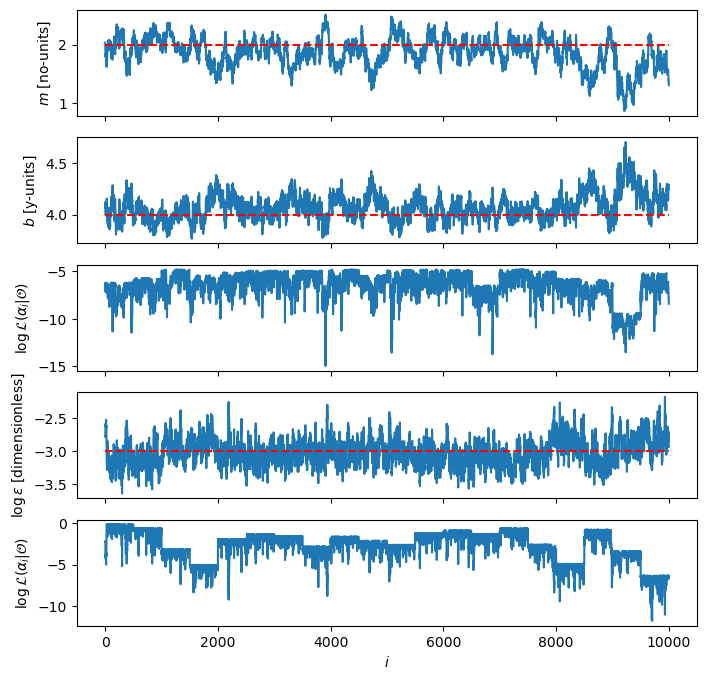

In [26]:
plot_chains(walker_metropolis, my_model, true_params)

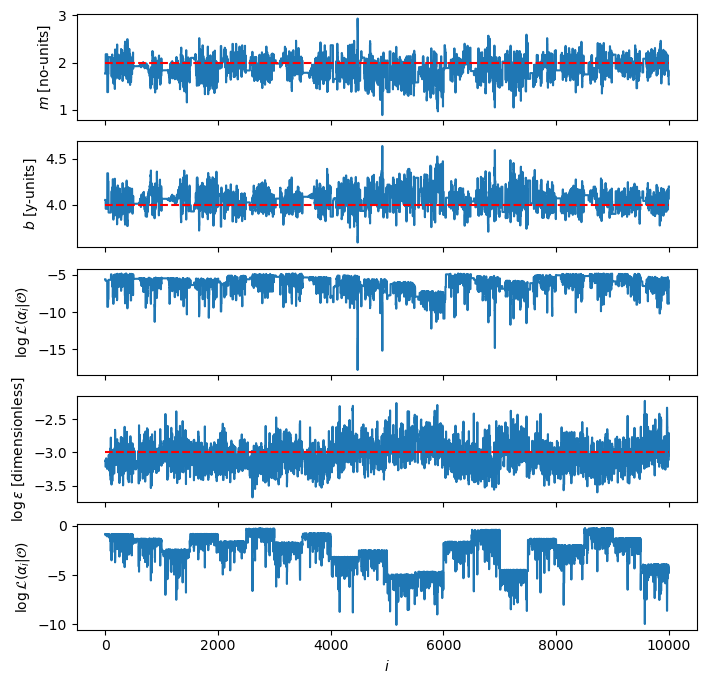

In [27]:
plot_chains(walker_adaptive, my_model, true_params)

In [34]:
def plot_posterior_corner(walker1, walker2):
    fig = corner.corner(
        np.hstack([walker1.model_chain, walker1.likelihood_chain[0]]),
        labels=[p.name for p in my_model.params]
        + [walker1.likelihood_sample_confs[0].params[0].name],
        label="posterior",
        truths=[true_params["m"], true_params["b"], np.log(noise)],
        color="tab:blue",
    )
    corner.corner(
        np.hstack([walker2.model_chain, walker2.likelihood_chain[0]]),
        fig=fig,
        color="tab:orange",
    )

    fig.suptitle("posterior")

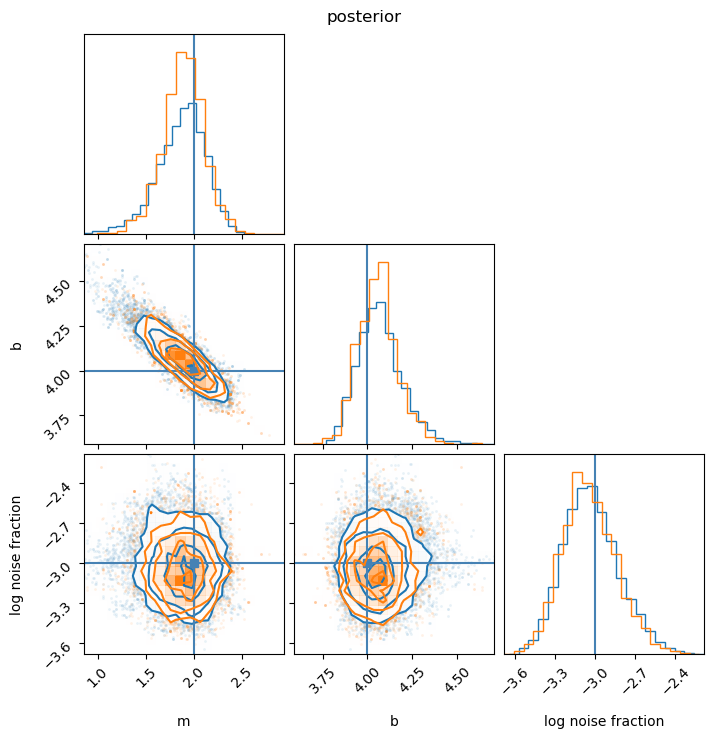

In [35]:
plot_posterior_corner(walker_metropolis, walker_adaptive)

In [36]:
def plot_predictive_post(walker1, walker2, model, x, x_data, y_exp, y_err):
    n_posterior_samples = walker1.model_chain.shape[0]
    y1 = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker1.model_chain[i, :]
        y1[i, :] = model.y(x, *sample)
    y2 = np.zeros((n_posterior_samples, len(x)))
    for i in range(n_posterior_samples):
        sample = walker2.model_chain[i, :]
        y2[i, :] = model.y(x, *sample)

    upper, lower = np.percentile(y1, [5, 95], axis=0)
    plt.fill_between(x, lower, upper, alpha=0.5, zorder=2, color="tab:blue")
    upper, lower = np.percentile(y2, [5, 95], axis=0)
    plt.fill_between(x, lower, upper, alpha=0.5, zorder=2, color="tab:orange")

    plt.plot(x, model.y(x, *true_params.values()), "k--", label="truth")
    plt.errorbar(
        x_data,
        y_exp,
        noise * y_data,
        color="k",
        marker="o",
        linestyle="none",
        label="experiment with bias",
    )

    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.legend()
    return upper, lower

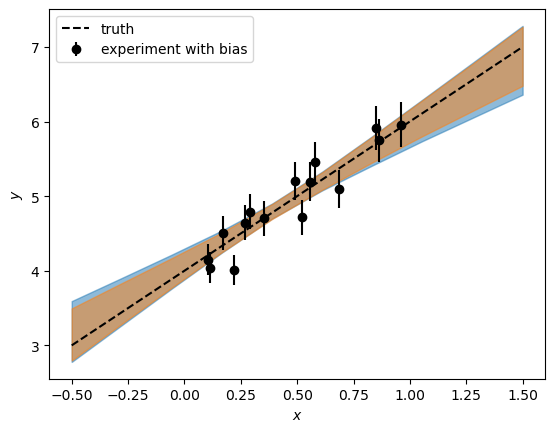

In [37]:
upper, lower = plot_predictive_post(
    walker_metropolis,
    walker_adaptive,
    my_model,
    np.linspace(-0.5, 1.5, 10),
    x_data,
    y_data,
    noise,
)